In [1]:
import numpy as np
from numpy import exp
from matplotlib import pyplot as plt
from scipy.interpolate import lagrange

In [2]:
lagrange_n = 4

# For console output
bold_open = '\033[1m'
bold_close = '\033[0m'

In [3]:
def n_closest(mesh, x, n):
    delta = abs(mesh - x)
    pairs = [(delta[i], i) for i in range(delta.shape[0])]
    pairs = sorted(pairs, key = lambda x: x[0])
    closest_indicies = [pairs[i][1] for i in range(n)]
    return closest_indicies

In [4]:
def lagrange_interp_point(basic_mesh, basic_values, x):
    closest = n_closest(basic_mesh, x, lagrange_n)
    polynomial = lagrange(basic_mesh[closest], basic_values[closest])
    return polynomial(x)

def lagrange_interp_mesh(basic_mesh, basic_values, target_mesh):
    target_values = np.zeros(target_mesh.shape[0])
    for i in range(target_mesh.shape[0]):
        target_values[i] = lagrange_interp_point(basic_mesh, basic_values, target_mesh[i])
    return target_values

In [5]:
def y_analytic(x):
    return (1 - exp(5*(x-1)))/(1 + 0.25*exp(5*(x-1)))

def dy_analytic(x):
    return -(1.25*(1 - exp(5*(x-1)))*exp(5*(x-1)))/((0.25*exp(5*(x-1)) + 1)**2) - 5*exp(5*(x-1))/(0.25*exp(5*(x-1)) + 1)

def y_linear(x, C_left, C_right, x_min, x_max):
    return C_left * x + C_right - C_left * x_max

def y_initial(x, C_left, C_right, x_min, x_max, alpha):
    return (1 - alpha) * y_analytic(x) + alpha * y_linear(x, C_left, C_right, x_min, x_max)

In [6]:
def qn(y):
    return (2*y + 3)

def pn(dy):
    return 2*dy

def phi_n(y, dy, ddy):
    return (2*y + 3)*dy - ddy

In [7]:
def adjust_approx(y_mesh, y_approx, v_mesh_N, C_left, C_right):
    matr_zero_d = np.zeros((v_mesh_N, v_mesh_N))
    matr_first_d = np.zeros((v_mesh_N, v_mesh_N))
    matr_second_d = np.zeros((v_mesh_N, v_mesh_N))
    v_mesh = np.linspace(y_mesh[0], y_mesh[-1], v_mesh_N)
    h = v_mesh[2] - v_mesh[1]
    
    for i in range(1, v_mesh_N - 1):
        matr_zero_d[i,i] = 1.0
        
        matr_first_d[i, i-1] = -1 /(2*h)
        matr_first_d[i, i+1] = 1/(2*h)
        
        matr_second_d[i,i] = -2/(h*h)
        matr_second_d[i, i-1] = 1/(h*h)
        matr_second_d[i, i+1] = 1/(h*h)
        
    q = np.zeros(v_mesh_N)
    p = np.zeros(v_mesh_N)
    phi = np.zeros(v_mesh_N)
    y = lagrange_interp_mesh(y_mesh, y_approx, v_mesh)
    
    dy = np.dot(matr_first_d, y)
    dy[0] = (-3*y[0] + 4*y[1] - y[2])/(2*h)
    dy[v_mesh_N-1] = (3*y[v_mesh_N-3] -4*y[v_mesh_N - 2] + y[v_mesh_N-1])/(2*h)
    
    ddy = np.dot(matr_second_d, y)
    
    for i in range(0, v_mesh_N):
        phi[i] = phi_n(y[i], dy[i], ddy[i])
        matr_first_d[i] = matr_first_d[i] * qn(y[i])
        matr_zero_d[i] = matr_zero_d[i] * pn(dy[i])
    
    # System Matrix
    M = matr_second_d - matr_first_d - matr_zero_d
    
    # Boundary conditions
    M[0] = np.zeros(v_mesh_N)
    M[v_mesh_N-1] = np.zeros(v_mesh_N)
    # Right edge
    M[v_mesh_N-1, v_mesh_N-1] = 1.0
    phi[v_mesh_N-1] = C_right - y[v_mesh_N-1]
    # Left edge
    M[0, 0] = -1.5/h
    M[0, 1] = 2/h
    M[0, 2] = -0.5/h
    phi[0] = C_left - dy[0]

    # Solving
    return np.dot(np.linalg.inv(M), phi)

In [8]:
def newton_method(max_steps, max_splits, y_mesh_n, init_intervs, x_min, x_max, C_left, C_right, alpha, eps):
    y_mesh = np.linspace(x_min, x_max, y_mesh_n)
    y_approx = np.array([y_initial(y_mesh[i], C_left, C_right, x_min, x_max, alpha) for i in range(y_mesh_n)])
    y_analyt = np.array([y_analytic(y_mesh[i]) for i in range(y_mesh_n)])
    v_norms = []
    errors = []
    approxes = [y_approx]
    adjusts = []
    
    print(f'{bold_open}Tsybakov Var.3 {bold_close}\n')
    for step in range(max_steps):
        print(f'{bold_open}Newton step {step+1}{bold_close}')
        intervs = init_intervs
        v_mesh_N = intervs + 1
        v_prev = adjust_approx(y_mesh, y_approx, v_mesh_N, C_left, C_right)
        if (step == 0):
            adjusts.append(v_prev)
        prev_norm = -1.0
        for split in range(max_splits):
            intervs = intervs * 2
            v_mesh_N = intervs + 1
            v_curr = adjust_approx(y_mesh, y_approx, v_mesh_N, C_left, C_right)
            if (step == 0):
                adjusts.append(v_curr)
            delta = v_prev - v_curr[range(0, v_mesh_N, 2)]
            norm = np.max(np.abs(delta))
            if (prev_norm == -1):
                print(f'  Iter {split+2}\t\tMesh: {intervs}\t|delta| = {norm:.3e}\tRatio = N/A')
            else:
                print(f'  Iter {split+2}\t\tMesh: {intervs}\t|delta| = {norm:.3e}\tRatio = {prev_norm/norm :.3f}')
            if (norm <= eps/2):
                v_prev = v_curr
                break
            prev_norm = norm
            v_prev = v_curr
        v_mesh = np.linspace(x_min, x_max, v_mesh_N)
        v_interp = lagrange_interp_mesh(v_mesh, v_curr, y_mesh)
        y_approx = y_approx + v_interp
        approxes.append(y_approx)
        v_norm = max(abs(v_interp))
        v_norms.append(v_norm)
        error = max(abs(y_analyt - y_approx))
        errors.append(error)
        print(f'{bold_open}Newton step {step+1} ended. |V| = {v_norm:.3e}, error = {error:.3e}{bold_close}\n')
        if (v_norm < eps/2 and error < eps):
            print(f'Converged, alpha = {alpha}')
            break
        if (v_norm < eps/2 and error >= eps):
            print('Converged to other solution, alpha = {alpha}')
            break
    return_dict = {
        'result': y_approx,
        'v_norms': v_norms,
        'eps_m_errors': errors,
        'approxes': approxes,
        'adjusts_0': adjusts
    }
    return return_dict

In [9]:
# Setting parameters
x_min = -1.0
x_max = 1.0

max_splits = 5
max_steps = 6
y_mesh_n = 128
init_intervs = 32

C_left = dy_analytic(x_min)
C_right = y_analytic(x_max)

alpha = 0.1
eps = 1e-4

y_initial:


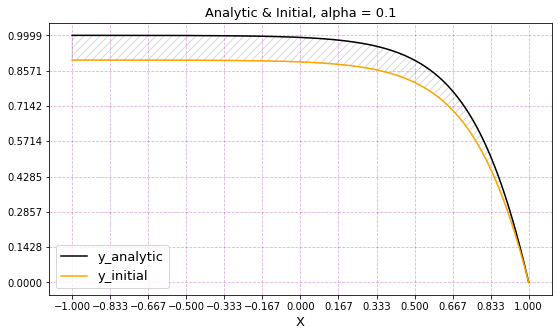

In [10]:
# Plotting Y_analytic & Y_initial
plot_mesh = np.linspace(x_min, x_max, 256)
plot_yini = np.array([y_initial(plot_mesh[i], C_left, C_right, x_min, x_max, alpha) for i in range(256)])
plot_yana = np.array([y_analytic(plot_mesh[i]) for i in range(256)])

fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(5)

plt.plot(plot_mesh, plot_yana, color = 'black', label = 'y_analytic')
plt.plot(plot_mesh, plot_yini, color = 'orange', label = 'y_initial')
plt.legend(fontsize = 13)
plt.grid(True, color = 'purple', alpha = 0.3, linestyle = '--')
plt.xlabel('X', fontsize = 13)
plt.title(f'Analytic & Initial, alpha = {alpha}', fontsize = 13)
plt.xticks(np.linspace(x_min, x_max, 13))
plt.yticks(np.linspace(np.min(plot_yana), np.max(plot_yana), 8))
plt.fill_between(plot_mesh, plot_yini, plot_yana, facecolor = 'none', edgecolor = 'grey', alpha = 0.3, hatch = '///')
print('y_initial:')

In [11]:
# Newton method
output = newton_method(max_steps, max_splits, y_mesh_n, init_intervs, x_min, x_max, C_left, C_right, alpha, eps)

Tsybakov Var.3 

Newton step 1
  Iter 2		Mesh: 64	|delta| = 4.096e-02	Ratio = N/A
  Iter 3		Mesh: 128	|delta| = 1.011e-02	Ratio = 4.051
  Iter 4		Mesh: 256	|delta| = 2.499e-03	Ratio = 4.046
  Iter 5		Mesh: 512	|delta| = 6.200e-04	Ratio = 4.030
  Iter 6		Mesh: 1024	|delta| = 1.544e-04	Ratio = 4.017
Newton step 1 ended. |V| = 1.158e-01, error = 1.582e-02

Newton step 2
  Iter 2		Mesh: 64	|delta| = 3.419e-02	Ratio = N/A
  Iter 3		Mesh: 128	|delta| = 8.270e-03	Ratio = 4.135
  Iter 4		Mesh: 256	|delta| = 2.030e-03	Ratio = 4.073
  Iter 5		Mesh: 512	|delta| = 5.027e-04	Ratio = 4.039
  Iter 6		Mesh: 1024	|delta| = 1.250e-04	Ratio = 4.020
Newton step 2 ended. |V| = 1.564e-02, error = 1.797e-04

Newton step 3
  Iter 2		Mesh: 64	|delta| = 3.466e-02	Ratio = N/A
  Iter 3		Mesh: 128	|delta| = 8.402e-03	Ratio = 4.125
  Iter 4		Mesh: 256	|delta| = 2.065e-03	Ratio = 4.070
  Iter 5		Mesh: 512	|delta| = 5.113e-04	Ratio = 4.038
  Iter 6		Mesh: 1024	|delta| = 1.272e-04	Ratio = 4.020
Newton step 3 ended. |V

In [12]:
y_approx = output['result']
v_norms = output['v_norms']
errors = output['eps_m_errors']
approxes = output['approxes']
adjusts_0 = output['adjusts_0']

y_approx:


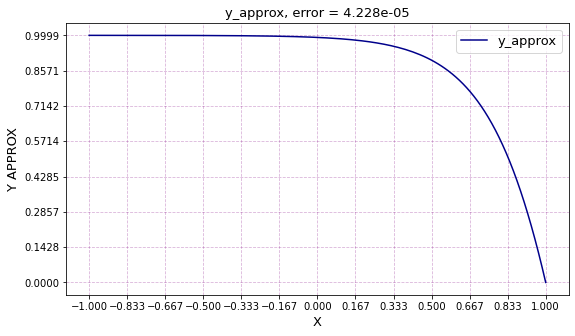

In [13]:
# Plotting results
y_mesh = np.linspace(x_min, x_max, y_mesh_n)

fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(5)

plt.plot(y_mesh, y_approx, color = 'darkblue', label = 'y_approx')
plt.legend(fontsize = 13)
plt.grid(True, color = 'purple', alpha = 0.3, linestyle = '--')
plt.xlabel('X', fontsize = 13)
plt.ylabel('Y APPROX', fontsize = 13)
plt.xticks(np.linspace(x_min, x_max, 13))
plt.yticks(np.linspace(np.min(y_approx), np.max(y_approx), 8))
plt.title(f'y_approx, error = {errors[-1]:.3e}', fontsize = 13)
print('y_approx:')

|vm|:


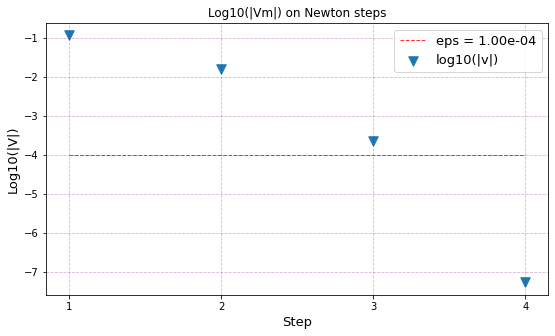

In [14]:
# Plotting v norms
fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(5)

# Steps 
ticks = np.arange(1, len(v_norms)+1)
plt.scatter(ticks, np.log10(v_norms), label = 'log10(|v|)', s = 90, marker= 'v')
plt.plot(ticks, np.ones(ticks.shape)*np.log10(eps), linestyle = '--', label = f'eps = {eps:.2e}', color = 'red', 
         linewidth = 1, alpha = 0.8)
plt.legend(fontsize = 13)
plt.grid(True, color = 'purple', alpha = 0.3, linestyle = '--')
plt.xlabel('Step', fontsize = 13)
plt.ylabel('Log10(|V|)', fontsize = 13)
plt.title('Log10(|Vm|) on Newton steps')
plt.xticks(ticks)
print('|vm|:')

|eps_M|:


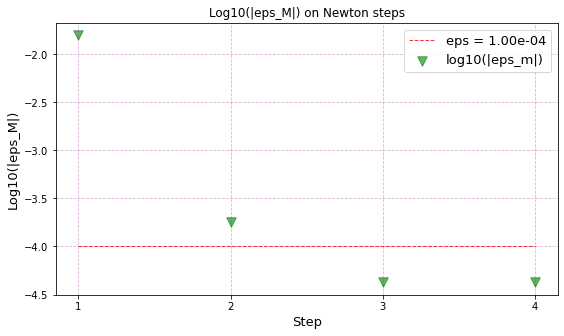

In [15]:
# Plotting errors eps_M
fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(5)

ticks = np.arange(1, len(errors) + 1)
plt.scatter(ticks, np.log10(errors), label = 'log10(|eps_m|)', s = 90, marker= 'v', color = 'green', alpha = 0.6)
plt.plot(ticks, np.ones(ticks.shape)*np.log10(eps), linestyle = '--', label = f'eps = {eps:.2e}', color = 'red', 
         linewidth = 1, alpha = 0.8)
plt.legend(fontsize = 13)
plt.grid(True, color = 'purple', alpha = 0.3, linestyle = '--')
plt.xlabel('Step', fontsize = 13)
plt.ylabel('Log10(|eps_M|)', fontsize = 13)
plt.title('Log10(|eps_M|) on Newton steps')
plt.xticks(ticks)
print('|eps_M|:')

approxes:


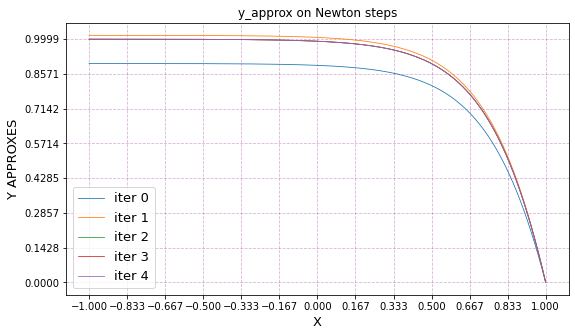

In [16]:
# Plotting y approximation on Newton steps
fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(5)

for i, approx in enumerate(approxes):
    plt.plot(y_mesh, approx, linewidth = 0.8, label = f'iter {i}')
    
plt.legend(fontsize = 13)
plt.grid(True, color = 'purple', alpha = 0.3, linestyle = '--')
plt.xlabel('X', fontsize = 13)
plt.ylabel('Y APPROXES', fontsize = 13)
plt.xticks(np.linspace(x_min, x_max, 13))
plt.yticks(np.linspace(np.min(y_approx), np.max(y_approx), 8))
plt.title('y_approx on Newton steps')
print('approxes:')

approxes:


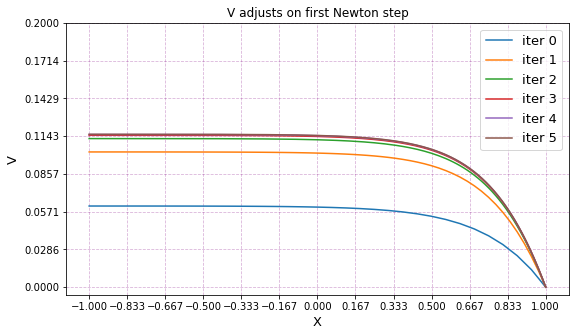

In [17]:
# Plotting adjustment on first Newton step
fig = plt.figure()
fig.set_figwidth(9)
fig.set_figheight(5)

for i, adjust in enumerate(adjusts_0):
    plt.plot(np.linspace(x_min, x_max, adjust.shape[0]), adjust, label = f'iter {i}')
    
plt.legend(fontsize = 13)
plt.grid(True, color = 'purple', alpha = 0.3, linestyle = '--')
plt.xlabel('X', fontsize = 13)
plt.ylabel('V', fontsize = 13)
plt.xticks(np.linspace(x_min, x_max, 13))
plt.yticks(np.linspace(0, 0.2, 8))
plt.title('V adjusts on first Newton step')
print('approxes:')